In [2]:
import pandas as pd

In [3]:
import glob

In [4]:
from bin.consol.utils import load_dataset
# import bin

gsmdf = load_dataset('gsm')
gsmdf

/Users/2katz/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,input,target
0,Janet’s ducks lay 16 eggs per day. She eats th...,18
1,A robe takes 2 bolts of blue fiber and half th...,3
2,Josh decides to try flipping a house. He buys...,70000
3,James decides to run 3 sprints 3 times a week....,540
4,"Every day, Wendi feeds each of her chickens th...",20
...,...,...
1314,John had a son James when he was 19. James is...,8
1315,There are some oranges in a basket. Ana spends...,5
1316,Mark's car breaks down and he needs to get a n...,230
1317,"Farmer Brown has 20 animals on his farm, all e...",5


In [5]:
def get_model_problem_summary(globpath, n=40):
    assert n <= 40
    df = pd.concat([pd.read_csv(filepath, index_col=0).head(n).assign(id=int(filepath.split("/")[-1].split('.')[0])) for filepath in sorted(glob.glob(globpath))]).reset_index(drop=True)
    df2 = gsmdf.target.to_frame()
    df2['answer'] = df.groupby('id').answer.agg(lambda x: x.value_counts().index[0])
    df2['trials'] = df.groupby('id').token_usage.count()
    df2['token_usage'] = df.groupby('id').token_usage.sum()
    return df2

def get_model_summary(df):
    return pd.Series({
        "mean_token_usage": df.token_usage.mean(),
        "estimated_price": df.token_usage.sum() * 4.40 / 1e6,
        "accuracy": (df.target == df.answer).mean(),
    })

get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*"))

mean_token_usage    5314.360395
estimated_price       30.819039
accuracy               0.941622
dtype: float64

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")


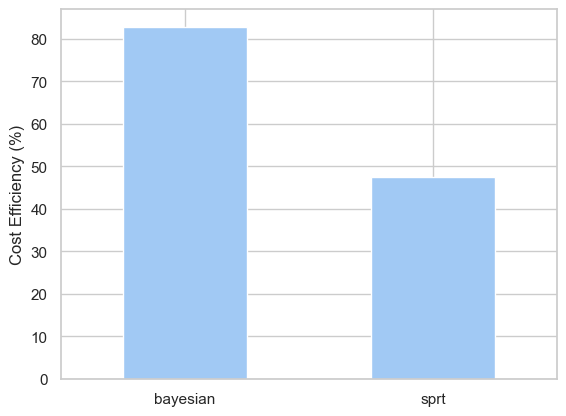

In [7]:
ax = (100 - 100*pd.Series([
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=40)).mean_token_usage / get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)).mean_token_usage,
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=40)).mean_token_usage / get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)).mean_token_usage,
    # get_model_summary(get_model_problem_summary("resources/o3minilow-aime24-bayesian/*", n=40)).mean_token_usage / get_model_summary(get_model_problem_summary("resources/o3minilow-aime24-vote/*", n=40)).mean_token_usage,
])).to_frame().assign(label=["bayesian", "sprt"]).set_index('label').plot.bar(ylabel="Cost Efficiency (%)", xlabel="", rot=0, legend=False)

# plt.savefig("cost_efficiency.pdf", bbox_inches='tight', dpi=300)

In [8]:
(
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=1)),
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=1)),

    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)),
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=40)),
)

(mean_token_usage    132.238240
 estimated_price       0.766876
 accuracy              0.891585
 dtype: float64,
 mean_token_usage    132.850644
 estimated_price       0.771012
 accuracy              0.884003
 dtype: float64,
 mean_token_usage    5314.360395
 estimated_price       30.819039
 accuracy               0.941622
 dtype: float64,
 mean_token_usage    2794.228961
 estimated_price       16.216587
 accuracy               0.945413
 dtype: float64)

In [9]:
(
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=1)),
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=1)),

    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)),
    get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=40)),
)

(mean_token_usage    132.238240
 estimated_price       0.766876
 accuracy              0.891585
 dtype: float64,
 mean_token_usage    132.978772
 estimated_price       0.771756
 accuracy              0.884761
 dtype: float64,
 mean_token_usage    5314.360395
 estimated_price       30.819039
 accuracy               0.941622
 dtype: float64,
 mean_token_usage    911.278241
 estimated_price       5.288694
 accuracy              0.941622
 dtype: float64)

<Axes: xlabel='max_trials', ylabel='estimated_price'>

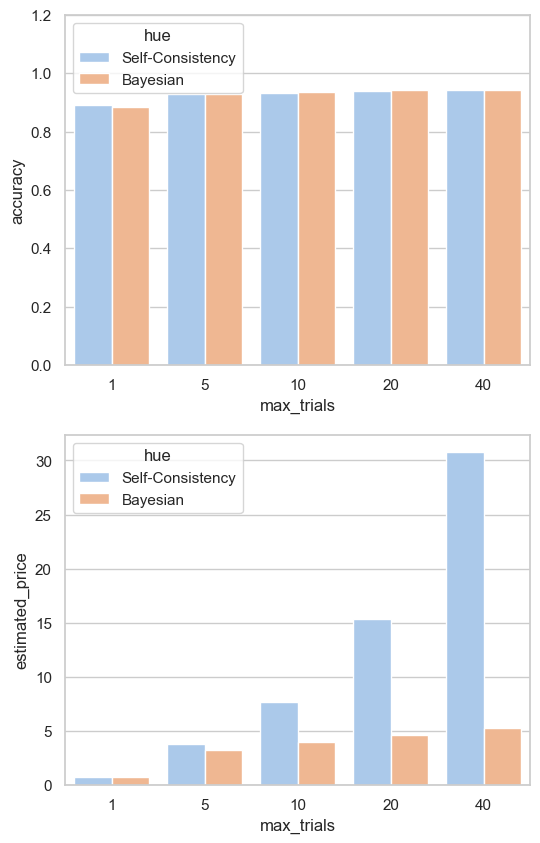

In [10]:
fig, axes = plt.subplots(2,1, figsize=(6, 10))
axes[0].set_ylim(0,1.2)

sns.barplot(
    data=pd.concat([
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=1)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=1)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=5)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=5)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=10)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=10)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=20)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=20)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=40)),
    ], axis=1).T.assign(max_trials=[1,1,5,5,10,10,20,20,40,40], hue=["Self-Consistency", "Bayesian"]*5),
    x="max_trials",
    y="accuracy",
    hue="hue",
    ax=axes[0],
)


sns.barplot(
    data=pd.concat([
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=1)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=1)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=5)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=5)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=10)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=10)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=20)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=20)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=40)),
    ], axis=1).T.assign(max_trials=[1,1,5,5,10,10,20,20,40,40], hue=["Self-Consistency", "Bayesian"]*5),
    x="max_trials",
    y="estimated_price",
    hue="hue",
    ax=axes[1],
)

<Axes: xlabel='max_trials', ylabel='estimated_price'>

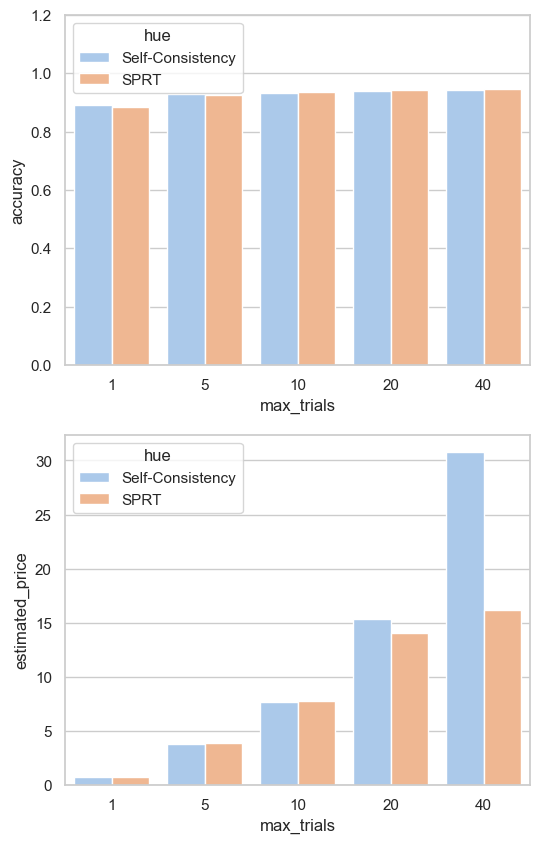

In [11]:
fig, axes = plt.subplots(2,1, figsize=(6, 10))
axes[0].set_ylim(0,1.2)

sns.barplot(
    data=pd.concat([
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=1)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=1)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=5)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=5)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=10)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=10)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=20)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=20)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=40)),
    ], axis=1).T.assign(max_trials=[1,1,5,5,10,10,20,20,40,40], hue=["Self-Consistency", "SPRT"]*5),
    x="max_trials",
    y="accuracy",
    hue="hue",
    ax=axes[0],
)


sns.barplot(
    data=pd.concat([
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=1)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=1)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=5)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=5)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=10)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=10)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=20)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=20)),

        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-vote/*", n=40)),
        get_model_summary(get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=40)),
    ], axis=1).T.assign(max_trials=[1,1,5,5,10,10,20,20,40,40], hue=["Self-Consistency", "SPRT"]*5),
    x="max_trials",
    y="estimated_price",
    hue="hue",
    ax=axes[1],
)

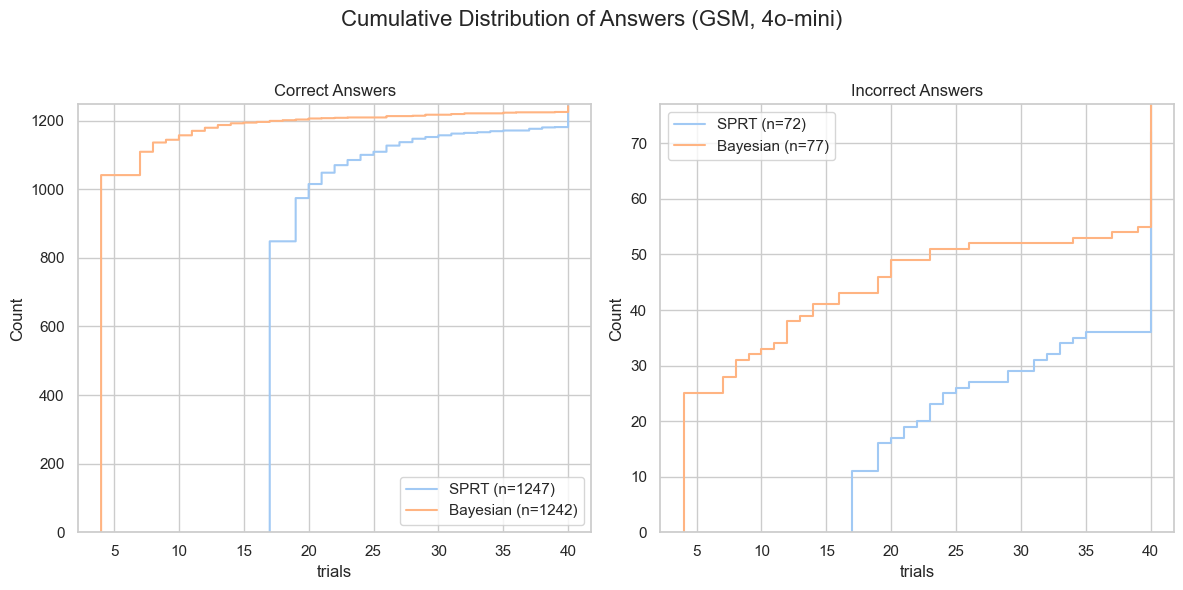

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Subplot Setup ---
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cumulative Distribution of Answers (GSM, 4o-mini)", fontsize=16)

# --- Correct Answers Subplot ---
# SPRT correct trials
df_sprt = get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=40)
correct_trials_sprt = df_sprt[df_sprt.target == df_sprt.answer].trials
sns.ecdfplot(data=correct_trials_sprt, 
             ax=ax1, 
             label=f"SPRT (n={len(correct_trials_sprt)})", 
             linestyle="solid", 
             stat="count")

# Bayesian correct trials
df_bayes = get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=40)
correct_trials_bayes = df_bayes[df_bayes.target == df_bayes.answer].trials
sns.ecdfplot(data=correct_trials_bayes, 
             ax=ax1, 
             label=f"Bayesian (n={len(correct_trials_bayes)})", 
             linestyle="solid", 
             stat="count")

ax1.set_title("Correct Answers")
ax1.legend()

# --- Incorrect Answers Subplot ---
# SPRT incorrect trials
df_sprt = get_model_problem_summary("resources/gpt4omini-gsm-sprt/*", n=40)
incorrect_trials_sprt = df_sprt[df_sprt.target != df_sprt.answer].trials
sns.ecdfplot(data=incorrect_trials_sprt, 
             ax=ax2, 
             label=f"SPRT (n={len(incorrect_trials_sprt)})", 
             linestyle="solid", 
             stat="count")

# Bayesian incorrect trials
df_bayes = get_model_problem_summary("resources/gpt4omini-gsm-bayesian/*", n=40)
incorrect_trials_bayes = df_bayes[df_bayes.target != df_bayes.answer].trials
sns.ecdfplot(data=incorrect_trials_bayes, 
             ax=ax2, 
             label=f"Bayesian (n={len(incorrect_trials_bayes)})", 
             linestyle="solid", 
             stat="count")

ax2.set_title("Incorrect Answers")
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figures/cdist-4o-mini-GSM.pdf", dpi=300, bbox_inches='tight')
plt.show()